# Portfolio Optimization

## Disclaimer
This file contains adaptations from IBM Qiskit CVaR Optimization Tutorial  
https://qiskit-community.github.io/qiskit-optimization/tutorials/08_cvar_optimization.html  
Original copyright (c) IBM 2017, 2024.  
Modified by Colin Farley (2025) for research use at HARP Research.  

## Objective

The goal of this notebook is to recreate, explain, and expand upon the CVaR-based variational quantum optimization techniques introduced by:

- Barkoutsos et al., Quantum 4, 256 (2020)

- IBM Qiskit’s SamplingVQE CVaR Tutorial

We focus on a mean-variance portfolio optimization problem  
Classical benchmarking using NumPyMinimumEigensolver  
We modularize the code to enable experimentation with different solvers, ansätze, and classical optimizers while ensuring reproducibility and educational value.

## 🧮 Problem Formulation: Mean-Variance Portfolio Optimization

We define a binary optimization problem where each variable $ x_i \in \{0, 1\} $ denotes whether to invest in asset $ i $.  
The objective is to **maximize expected return** while **penalizing risk** via a covariance matrix.  
A budget constraint enforces the total number of selected assets.

Formulation:
$
\text{maximize} \quad \mu^T x - q \cdot x^T \Sigma x \quad \text{subject to} \quad \sum x_i = \text{budget}
$


In [ ]:
from experiments.cvar_portfolio.data_utils import load_default_portfolio
from experiments.cvar_portfolio.objective_portfolio import portfolio_to_qp

mu, sigma = load_default_portfolio()
qp = portfolio_to_qp(mu, sigma, 0.5)
print(qp.prettyprint())


Problem name: portfolio_optimization

Maximize
  -0.3656*x_0^2 + 0.6233*x_0*x_1 - 0.4689*x_0*x_2 + 0.5452*x_0*x_3
  + 0.0082*x_0*x_4 + 0.3809*x_0*x_5 - 1.2366*x_1^2 + 0.7538*x_1*x_2
  - 2.4659*x_1*x_3 + 0.0733*x_1*x_4 - 0.8945*x_1*x_5 - 0.57715*x_2^2
  + 1.4095*x_2*x_3 - 0.0007*x_2*x_4 + 0.4301*x_2*x_5 - 1.75335*x_3^2
  - 0.2012*x_3*x_4 - 1.0922*x_3*x_5 - 0.31155*x_4^2 - 0.1509*x_4*x_5
  - 0.4496*x_5^2 + 0.7313*x_0 + 0.9893*x_1 + 0.2725*x_2 + 0.875*x_3 + 0.7667*x_4
  + 0.3622*x_5

Subject to
  Linear constraints (1)
    x_0 + x_1 + x_2 + x_3 + x_4 + x_5 == 3  'c0'

  Binary variables (6)
    x_0 x_1 x_2 x_3 x_4 x_5



## 🧪 Classical Baseline

Before exploring quantum approaches, we solve the constrained problem classically using an exact eigensolver (`NumPyMinimumEigensolver`).  
This provides a **ground truth** for benchmarking quantum algorithms.


In [16]:
from experiments.cvar_portfolio.objective_portfolio import classic_solve

classical_result = classic_solve(qp)
print(classical_result.prettyprint())

objective function value: 1.27835
variable values: x_0=1.0, x_1=1.0, x_2=0.0, x_3=0.0, x_4=1.0, x_5=0.0
status: SUCCESS


## 🔄 Constraint Handling and Hamiltonian Mapping

Quantum solvers typically require unconstrained problems in Ising or QUBO form.  
We use `LinearEqualityToPenalty` to transform our constraint into a **penalty term**, then convert to a Pauli-based Hamiltonian via `.to_ising()`.

This is essential for applying algorithms like SamplingVQE and QAOA.


In [17]:
from experiments.cvar_portfolio.objective_portfolio import portfolio_add_penalty

penalty = 12                                    #2 * n
qp = portfolio_add_penalty(qp, penalty)
hamiltonian, offset = qp.to_ising()  
print(hamiltonian) 
print(offset)

SparsePauliOp(['IIIIIZ', 'IIIIZI', 'IIIZII', 'IIZIII', 'IZIIII', 'ZIIIII', 'IIIIZZ', 'IIIZIZ', 'IIZIIZ', 'IZIIIZ', 'ZIIIIZ', 'IIIZZI', 'IIZIZI', 'IZIIZI', 'ZIIIZI', 'IIZZII', 'IZIZII', 'ZIIZII', 'IZZIII', 'ZIZIII', 'ZZIIII'],
              coeffs=[ 0.455025+0.j, -0.60115 +0.j,  0.378625+0.j, -0.890325+0.j,  0.15975 +0.j,
 -0.37535 +0.j,  5.844175+0.j,  6.117225+0.j,  5.8637  +0.j,  5.99795 +0.j,
  5.904775+0.j,  5.81155 +0.j,  6.616475+0.j,  5.981675+0.j,  6.223625+0.j,
  5.647625+0.j,  6.000175+0.j,  5.892475+0.j,  6.0503  +0.j,  6.27305 +0.j,
  6.037725+0.j])
18.610925000000012


In [ ]:
from qiskit.circuit.library import RealAmplitudes
from qiskit_algorithms.optimizers import COBYLA
from qiskit.primitives import Sampler

n = 6 # num of binary variables

# set classical optimizer
maxiter = 100
optimizer = COBYLA(maxiter=maxiter)

# set variational ansatz
ansatz = RealAmplitudes(n, reps=1)
m = ansatz.num_parameters

# set sampler
sampler = Sampler()

alphas = [1.0, 0.50, 0.25]  # confidence levels to be evaluated

In [ ]:
from qiskit_algorithms import SamplingVQE
from qiskit_optimization.algorithms import MinimumEigenOptimizer
import numpy as np

# dictionaries to store optimization progress and results
objectives = {alpha: [] for alpha in alphas}  # set of tested objective functions w.r.t. alpha
results = {}                                  # results of minimum eigensolver w.r.t alpha

# callback to store intermediate results
def callback(i, params, obj, stddev, alpha):
    # we translate the objective from the internal Ising representation
    # to the original optimization problem
    val = np.real_if_close(-(obj + offset))
    print(f"iter={i:3d}  alpha={alpha:.2f}  obj={val:.4f}")
    objectives[alpha].append(val)


# loop over all given alpha values
for alpha in alphas:

    # initialize SamplingVQE using CVaR
    vqe = SamplingVQE(
        sampler=sampler,
        ansatz=ansatz,
        optimizer=optimizer,
        aggregation=alpha,
        callback=lambda i, params, obj, stddev: callback(i, params, obj, stddev, alpha),
    )

    # initialize optimization algorithm based on CVaR-SamplingVQE
    opt_alg = MinimumEigenOptimizer(vqe)

    # solve problem
    results[alpha] = opt_alg.solve(qp)

    # print results
    print("alpha = {}:".format(alpha))
    print(results[alpha].prettyprint())
    print()

iter=  1  alpha=1.00  obj=-14.8804
iter=  2  alpha=1.00  obj=-14.2837
iter=  3  alpha=1.00  obj=-15.8697
iter=  4  alpha=1.00  obj=-15.3473
iter=  5  alpha=1.00  obj=-9.6508
iter=  6  alpha=1.00  obj=-7.7791
iter=  7  alpha=1.00  obj=-4.3508
iter=  8  alpha=1.00  obj=-5.8712
iter=  9  alpha=1.00  obj=-8.6189
iter= 10  alpha=1.00  obj=-2.9214
iter= 11  alpha=1.00  obj=-6.7806
iter= 12  alpha=1.00  obj=-5.6225
iter= 13  alpha=1.00  obj=-6.3670
iter= 14  alpha=1.00  obj=-3.7743
iter= 15  alpha=1.00  obj=-3.7686
iter= 16  alpha=1.00  obj=-6.9799
iter= 17  alpha=1.00  obj=-4.7930
iter= 18  alpha=1.00  obj=-5.2714
iter= 19  alpha=1.00  obj=-5.9560
iter= 20  alpha=1.00  obj=-3.1200
iter= 21  alpha=1.00  obj=-3.6982
iter= 22  alpha=1.00  obj=-3.0500
iter= 23  alpha=1.00  obj=-3.1545
iter= 24  alpha=1.00  obj=-3.1806
iter= 25  alpha=1.00  obj=-2.8889
iter= 26  alpha=1.00  obj=-2.8654
iter= 27  alpha=1.00  obj=-2.6700
iter= 28  alpha=1.00  obj=-2.7063
iter= 29  alpha=1.00  obj=-1.7823
iter= 30  

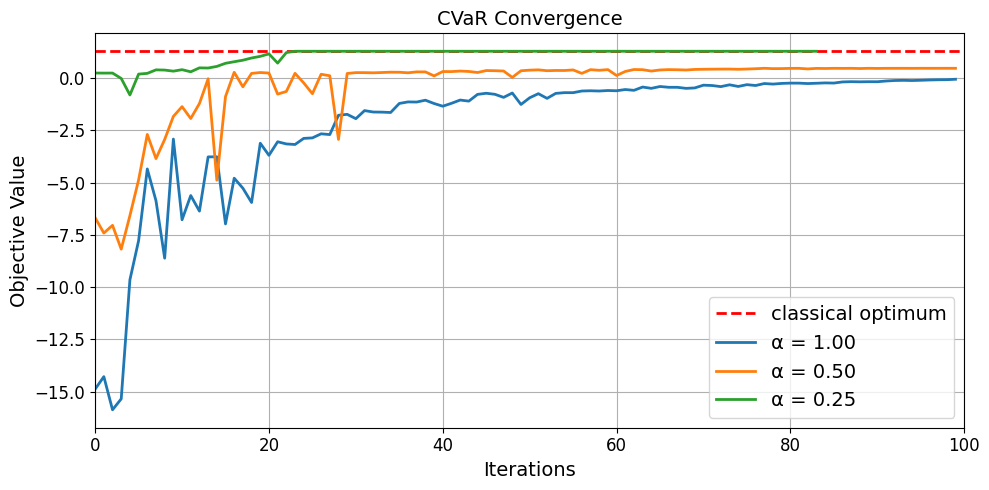

In [20]:
from experiments.cvar_portfolio.plot_cvar_history import plot_cvar_convergence

plot_cvar_convergence(
    objectives,             # dict: {alpha: [objective values per iteration]}
    classical_result.fval,  # float: classical optimum to plot as dashed line
    maxiter,                # int: max number of optimization steps
    "CVaR Convergence"      # str: optional plot title
)